Retrieval Augmented Generation (RAG) es una técnica usada para chatbots con LLMs que permite a estos acceder a información muy especifica para realizar acciones como responder preguntas (Q&A). En este notebook se detalla la implementación minima para permitir a un LLM hacer uso de información sin necesidad de cargar todo a su ventana de contexto.

# Overview

Tipicamente los RAG tienen dos componentes:
  
* Indexing: un pipeline para ingestar los datos e indexarlos
* Retrieval and generation: el uso de a información generada en el RAG, que toma una query del usuario y regresa toda la información relevante relacionada que este en el index, para despues pasarsela al modelo.

## Indexing

El indexing usualmente consiste de estos pasos:

* Load: primero se cargan los datos haciendo uso de Document Loaders. Hay que considerar que dependiendo el problema, se puede requerir mucho esfuerzo para obtener esos datos: pre-procesamiento a documents, uso de visual transformers y otras tools para bajar datos no estructurados a semi-estructurados es un claro ejemplo de la complejidad que conlleva este paso.
* Split: Text splitters dividen Documents muy largos en chunks (pedazos). Esto sirve para indexar la información de manera más granular y reducir la cantidad de información que se le pasa al contexto del modelo. Existen diversas estrategias de chunking, dependerá mucho del problema.
* Store: Se necesita un lugar para guardar e indexar los chunks para que puedan ser consultados, esto se logra usando VectorStores y Embeddings para "traducir" el texto a vectores.

## Retrieval and generation

Esta sección se compone de dos elementos:
* Retrieve: El usuario da una input y los chunks más relevantes (relacionados con el input) son tomados del Vector Store.
* Generate: Un LLM produce una respuesta al recibir una prompt que incluye una pregunta (o query hecha por el usuario) y un contexto (chunks del retrieval)

# Compontents

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-3.5-turbo", model_provider="openai")

In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
from langchain_postgres import PGVector
import os

vector_store = PGVector(
    embeddings=embeddings,
    collection_name="rag_part_1",
    connection=os.getenv("PGVECTOR_CONN_STRING")
)

# Detailed Walthrough
## Indexing

### Loading documents

Para este notebook se cargará el texto de un blog como información para usar en el RAG.

Para cargar el contenido del blog se necesitará un Document Loader, estos son objetos que cargan información de una fuente y retornan una lista de objetos Document.

En este caso se usará WebBaseLoader. Este hace uso por detras de urllib para cargar el HTML; y se complementará con BeatifulSoup para parsear el HTML a texto.

Se puede customizar el parseo de BeautifulSoup usando bs_kwargs. En este caso, solo etiquetas HTML con clase "post-content", "post-title", o "post-header" se tomarán, ignorando las demás.

In [6]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

bs4_strainer = bs4.SoupStrainer(class_=("post-title","post-header","post-content"))

loader = WebBaseLoader(
    web_path=("https://lilianweng.github.io/posts/2023-06-23-agent",),
    bs_kwargs={"parse_only":bs4_strainer}
)

docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 43130


In [7]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Splitting documents

El documento cargado tiene más de 43k caracteres, lo que podría superar la ventana de contexto máxima de algunos modelos y/o ser muy caro de procesar. Para manejar esta situación se puede dividir el texto en chunks para que luego solo sea necesario hacer el retrieval de las partes necesarias para responder una pregunta y al mismo tiempo reducir la cantidad de tokens que se le envian al modelo.

RecursiveCharacterTextSplitter nos permite hacer el text splitting con los parametros ajustados que puedan ser necesarios para el tamaño del problema. Este es un metodo bastante bueno para hacer el splitting de texto generico. Otros tipos de textos, como libros, podrían beneficiarse más de otro tipo de splitting.

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
    add_start_index=True,
)

all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 66 sub-documents.


### Storing documents

Para guardar los 66 chunks (sub-documents) para poder hacer el retrieval, se necesita que el embedding vectorize cada documento para poder ser almacenados en el Vector Store. En la sección de Componentes se establece una conexión con PGVector (Postgres con una extensión) que será el Vector Store y se le pasó como argumento un embedding de OpenAI se encargará en hacer los embeddings.

In [9]:
documents_ids = vector_store.add_documents(documents=all_splits)

In [10]:
print(documents_ids[:3])

['bc5d0ac2-1407-426a-8b40-8349e5d52dcb', '3d55dd34-e7ba-47c7-bd5c-c5224a5439ff', '37328a34-576b-4a13-baa9-28a9fa1b4d36']


En este punto ya esta completado el indexing de la información y se tiene una Vector Store conteniendo los chunks de información del blog y con capacidad de responder a consultas.

## Retrieval and Generation

Ahoara se creeará una aplicación simple que toma una pregunta del usuario, realiza la busqueda de documentos (chunks) relevantes a la pregunta, envía esos documentos relevantes como contexto al modelo, y este produce una respuesta.

Primero especificamos una prompt para RAG que se puede encontrar en el prompt hub de LangChain:

In [11]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context":"(context goes here)","question":"(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

/Users/dextergomez/miniconda3/envs/rag/lib/python3.10/site-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:


LangGraph nos permite integrar la parte de retrieval y generation en una sola aplicación. Esto trae bastantes beneficios:
* Una vez definida la logica de la aplicación, esta automaticamente soportará diferentes metodos de invocación.
* Se podría hacer uso de despliegues en LanGraph Platform.
* LangSmith automaticamente hará seguimiento de los pasos de la aplicación.
* Es más fácil así añadir caracteristicas a la aplicación como persistencia de memoria o humman-in-the-loop approval con cambios minimos.

Para hacer uso de LangGraph se necesitan tres componentes:
* Un State (estado) para la aplicación
* Los nodos de la aplicación
* El flujo de control de la aplicación

### State
El State o estado de la aplicación controla como las datos son entregados a la aplicación, como estos son transferidos entre los nodos, y finalmente como esta es entregada en la salida. Comunmente se utiliza TypedDict aunque tambien se puede hacer uso de Pydantic BaseModel

Para un RAG básico solo necesitariamos tener los siguientes datos: una pregunta de entraga (question), el contexto para responder la pregunta que se obtendra del Vector Store (context), y una respuesta generada (answer):

In [12]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### Nodes (application steps)

In [13]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

In [14]:
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question":state["question"],"context":docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

El nodo retrieve corre una busqueda de similaridad de la pregunta de entrada en el Vector Store, y el nodo de generate formatea el texto recuperado como contexto y la pregunta original para estructurar una prompt y envirla al modelo.

### Control Flow

Finalmente compilamos nuestra aplicación en un solo graph object. En esta aplicación solamente es la integración de los nodos retrieve y generate en una sola secuencia de ejecución:

In [15]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START,"retrieve")

graph = graph_builder.compile()

LanGraph trae funciones para visualizar el flujo de control de la aplicación:

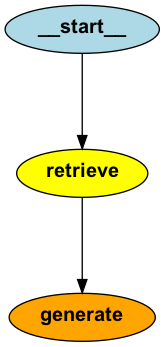

In [23]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

### RAG Usage

In [24]:
result = graph.invoke({"question":"What is Task Decomposition?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='37328a34-576b-4a13-baa9-28a9fa1b4d36', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='9c2285f8-2816-45cb-8bd8-38be0af2fa11', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023) extends CoT by 

In [30]:
for step in graph.stream(
    {"question":"What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n---------------\n")

{'retrieve': {'context': [Document(id='37328a34-576b-4a13-baa9-28a9fa1b4d36', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent', 'start_index': 1585}, page_content='Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.'), Document(id='9c2285f8-2816-45cb-8bd8-38be0af2fa11', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent', 'start_index': 2192}, page_content='Tree of Thoughts (Yao et al. 2023)

In [31]:
for message, metadata in graph.stream(
    {"question":"What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

|Task| Decom|position| involves| breaking| down| complex| tasks| into| smaller|,| more| manageable| steps| using| techniques| like| Chain| of| thought| and| Tree| of| Thoughts|.| This| process| can| be| done| using| simple| prompting|,| task|-specific| instructions|,| or| human| inputs|.| In| the| context| of| an| AI| assistant| system|,| task| decomposition| helps| in| parsing| user| input| into| multiple| tasks| with| dependencies| and| arguments| for| efficient| task| planning| by| the| system|.||

# Query analysis

Hasta ahora estamos realizando el retrieval usando una query de entrada cruda. Se puede usar el modelo para generar una query para el retrieval, añadiendo caracteristicas a este proceso. Como:

* Además del semantic search, se pueden construir filtros estructurados (como buscar en cierto rango de fechas).
* El modelo puede re-escribir queries que ambiguas o con información irrelevante para lograr una busqueda más efectiva.

El query analysis se añade como un paso más a la aplicación, justo antes del retrieval, para mejorar la query. En este caso se hará un ejemplo "ilustrativo" donde se divide el documento entres partes y esta información se añade al metadata para permitirnos filtrar por este.

In [32]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    elif i < 3 * third:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent',
 'start_index': 8,
 'section': 'beginning'}

Ahora necesitamos actualizar los documentos del Vector Store. Pero para este caso, se usará InMemoryVectorStore ya que esta trae algunas caracteristicas de las que se sacará provecho.

In [33]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

_ = vector_store.add_documents(all_splits)

Se definie primero un schema para el search query. Aquí se define la query que contiene un string (la query) y una sección del documento (que servirá como filtro).

In [34]:
from typing import Literal
from typing_extensions import Annotated

class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beggining","middle","end"],
        ...,
        "Section to query.",
    ]

Finalmente se crea el nuevo estado donde se realiza el query analysis, y se añade un filtro al nodo de retrieve haciendo uso del nuevo metadata.

In [35]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query":query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter= lambda doc: doc.metadata.get("section") == query["section"]
    )
    return {"context":retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [36]:
graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

Se compila y muestra el nuevo flujo de ejecución

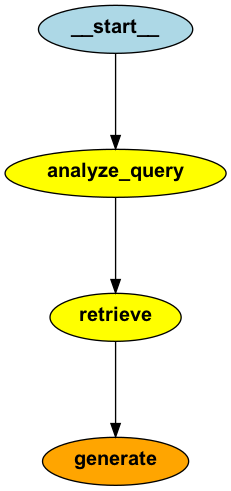

In [37]:
display(Image(graph.get_graph().draw_png()))

Y se hace la prueba de su funcionamiento:

In [38]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

/Users/dextergomez/miniconda3/envs/rag/lib/python3.10/site-packages/langchain_openai/chat_models/base.py:1382: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'analyze_query': {'query': {'query': 'Task Decomposition', 'section': 'end'}}}

----------------

{'retrieve': {'context': [Document(id='1e700ab3-941e-4986-b376-e80bfd89f804', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent', 'start_index': 33070, 'section': 'end'}, page_content='You will get instructions for code to write.\nYou will write a very long answer. Make sure that every detail of the architecture is, in the end, implemented as code.\nMake sure that every detail of the architecture is, in the end, implemented as code.\nThink step by step and reason yourself to the right decisions to make sure we get it right.\nYou will first lay out the names of the core classes, functions, methods that will be necessary, as well as a quick comment on their purpose.\nThen you will output the content of each file including ALL code.\nEach file must strictly follow a markdown code block format, where the following tokens must be replaced such that\nFILENAME is the lower

Existen muchas maneras de realizar el query analysis, así que dependerá mucho (como siempre) del problema que se busque resolver.